# Calibration of Qubit 2 (14N)

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import importlib
import libxq1i
importlib.reload(libxq1i)

try: 
   pulsed_master_logic
except NameError:
   manager.startModule('logic', 'pulsed_master_logic')

xq1i = libxq1i.xq1i(pulsed_master_logic, pulsed_measurement_logic, sequence_generator_logic)

In [ ]:
#Measure Qubit-1 transition frequency#
res_freq = 1.448466e9
xq1i.generate_params['microwave_frequency'] = res_freq
xq1i.pulsedODMR_params['freq_start'] = res_freq - 5.0e6
xq1i.pulsedODMR_params['freq_step'] = 0.1e6
xq1i.pulsedODMR_sweeps = 80000 
xq1i.do_pulsedODMR()
time.sleep(2)
result_dict = xq1i.pulsed_measurement_logic.do_fit('Lorentzian Dip')
xq1i.res_freq = result_dict.params['center'].value
time.sleep(2)

#Measure Qubit-1 gate parameters#
xq1i.rabi_sweeps = 80000
xq1i.do_rabi(isSlow=False)    # perform fast Rabi
result_dict = xq1i.pulsed_measurement_logic.do_fit('Sine')
xq1i.rabi_period_HighPower = 1/(result_dict.params['frequency'].value)   
xq1i.generate_params['rabi_period'] = xq1i.rabi_period_HighPower
xq1i.pulsed_master_logic.set_generation_parameters(xq1i.generate_params)
#xq1i.pulsed_measurement_logic.do_fit('No Fit')
time.sleep(2)

#Measure Qubit-2 transition frequency m_s=0#
xq1i.nucspect_params['NV_pi'] = False
xq1i.nucspect_params['freq_start'] = 5.05e6
xq1i.nucspect_sweeps = 80000
xq1i.do_Nucspect()
time.sleep(2)    
result_dict = xq1i.pulsed_measurement_logic.do_fit('Lorentzian Dip')
xq1i.RF_freq0 = result_dict.params['center'].value

#Measure Qubit-2 gate parameters m_s=0#
xq1i.nucrabi_params['NV_pi'] = False
xq1i.nucrabi_sweeps = 80000
xq1i.do_NucRabi()
result_dict = xq1i.pulsed_measurement_logic.do_fit('Sine')
xq1i.nucrabi_RFfreq0_period = 1/(result_dict.params['frequency'].value) 

#Measure Qubit-2 transition frequency m_s=1#
xq1i.nucspect_params['NV_pi'] = True
xq1i.nucspect_params['freq_start'] = 2.90e6
xq1i.nucspect_sweeps = 80000
xq1i.do_Nucspect()
time.sleep(2)    
result_dict = xq1i.pulsed_measurement_logic.do_fit('Lorentzian Dip')
xq1i.RF_freq1 = result_dict.params['center'].value

#Measure Qubit-2 gate parameters m_s=1#
xq1i.nucrabi_params['NV_pi'] = True
xq1i.nucrabi_sweeps = 80000
xq1i.do_NucRabi()
result_dict = xq1i.pulsed_measurement_logic.do_fit('Sine')
xq1i.nucrabi_RFfreq1_period = 1/(result_dict.params['frequency'].value) 

# # #DDRF transition frequency measurement
# outfile = open("./14N_Calibration/DDRFamplist_freq_{:.0f}.txt".format(xq1i.DDrfspect_params['freq']), "w")
# DDRFamplist = []
# freqls = np.arange(2.9e6,3.00e6,2e3).tolist()
# for freq in freqls:
#     xq1i.DDrfspect_params['RF_freq'] = freq
#     xq1i.DDrfspect_sweeps = 100000
#     xq1i.do_DDrf_Spect()
#     result_dict = xq1i.pulsed_measurement_logic.do_fit('Sine_Fixed_Freq_360')
#     amplitude = float(result_dict.params['amplitude'].value)
#     DDRFamplist.append([freq,amplitude])
#     outfile.write("{:.15f}\t{:.15f}\n".format(freq, amplitude))
#     outfile.flush()
#     time.sleep(2)
# outfile.close()
# fig = plt.figure()
# ax = plt.axes()
# ax.set_title('DDRF calibration')
# ax.set_xlabel('frequency in Hz')
# ax.set_ylabel('amplitude')
# DDRFampArray = np.array(DDRFamplist)
# ax.plot(DDRFampArray[:,0], DDRFampArray[:,1])
# plt.show()

#Measure Qubit-1 transition frequency#
res_freq = 1.449466e9
xq1i.generate_params['microwave_frequency'] = res_freq
xq1i.pulsedODMR_params['freq_start'] = res_freq - 5.0e6
xq1i.pulsedODMR_params['freq_step'] = 0.1e6
xq1i.pulsedODMR_sweeps = 80000 
xq1i.do_pulsedODMR()
time.sleep(2)
result_dict = xq1i.pulsed_measurement_logic.do_fit('Lorentzian Dip')
xq1i.res_freq = result_dict.params['center'].value
time.sleep(2)

#calibration of CnNOTe (if nuclear spin in state 0, electron spin is flipped)#
xq1i.rabi_sweeps = 80000
xq1i.do_rabi(isSlow=True)    # perform slow Rabi
result_dict = xq1i.pulsed_measurement_logic.do_fit('Sine')
xq1i.rabi_period_LowPower = 1/(result_dict.params['frequency'].value)
amp = float(result_dict.params['amplitude'].value)
offset = float(result_dict.params['offset'].value)
time.sleep(2)


xq1i.QCQB12_params['Initial_state'] = libxq1i.TQstates.State01
xq1i.QCQB12_sweeps = 300000
qcQB12 = [
     xq1i.gate("noop", param=100.0e-9),
     #xq1i.gate("sx", 1),
     xq1i.gate("c0x", 2),
     #xq1i.gate("c0x", 1),
]
xq1i.do_QuantumCircuitQB12(qcQB12)

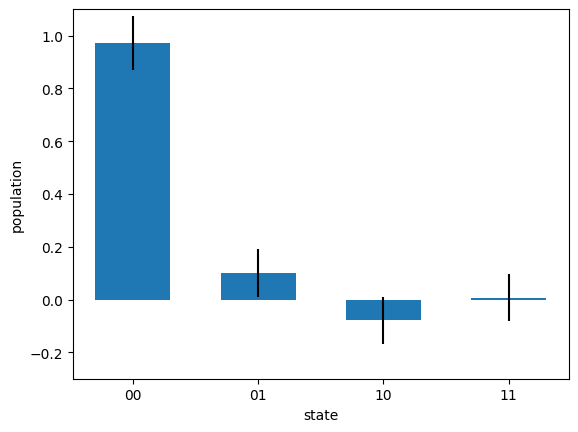

In [53]:
amp = float(amp)
offset = float(offset)

raw_populations = np.array( [(float(ppl)-(offset-amp))/(2*amp) for ppl in pulsed_measurement_logic.signal_data[1]] )
populations = (1 - np.sum(raw_populations))/4 + raw_populations

fig, ax = plt.subplots()
ax.bar(['00', '01', '10', '11'], populations,
       yerr = [float(err)/(2*amp) for err in pulsed_measurement_logic.measurement_error[1]],
       width=0.6)
ax.set_xlabel('state')
ax.set_ylabel('population')
ax.set_ylim( (-0.3, 1.1) )
plt.show()

In [ ]:
from qudi.logic.pulsed.predefined_generate_methods.qubit_control_methods import Gates
from enum import Enum

def isEnumMember(enum, nameElemCandidate):
    for elem in enum:
        if elem.name == nameElemCandidate:
            return True
    return False

circ_gates = [Gates.NOOP, Gates.ucq1Sqrtz, Gates.CnNOTe]
gate_operations = ", ".join([gate.name for gate in circ_gates])
print(gate_operations)
oper_list = [Gates[oper].name for oper in gate_operations.replace(" ", "").split(",")]
print(oper_list)

for oper in oper_list:
    print(isEnumMember(Gates, oper))

myCirc = [ s
    xq1i.gate("sx", 1), 
    xq1i.gate("rz", 2, param=90),
    xq1i.gate("sx", 2),
    xq1i.gate("c0x", 2),
    xq1i.gate("rz", 1, param=90),
    xq1i.gate("c1x", 2),
    xq1i.gate("c0x", 1)
]
myCircStringRepr = ", ".join([f"{gate.name}({gate.param})[{gate.qubit}]"  for gate in myCirc])
print(myCircStringRepr)